# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 17.09.2019

Мягкий дедлайн: 23:59MSK 29.09.2019 (за каждый день просрочки снимается 2 балла)

Жесткий дедлайн: 23:59MSK 02.10.2019

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а также привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. 

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: xx.

<strong style="color: red">Внимание!</strong> В этом ноутбуке используется библиотека `ipyleaflet`. Чтобы ее установить так, чтобы она работала, нужно совершить 2 простых шага:

In [1]:
! jupyter nbextension enable --py --sys-prefix ipyleaflet

Enabling notebook extension jupyter-leaflet/extension...
      - Validating: OK


После этого перезапустите сессию (не `Restart Kernel`, а нажмите `Ctrl+C` в терминале, где вы запускали ноутбук, и запустите заново). Лучше это сделать сразу, чтобы потом не пришлось прерывать сессию и терять промежуточные результаты работы. Если все сделано правильно, вы должны увидеть карту Москвы, выполнив ячейку ниже:

In [2]:
from ipyleaflet import Map, basemaps
Map(center=(55.7522200, 37.6155600), zoom=10, basemap=basemaps.Esri.NatGeoWorldMap)

Map(center=[55.75222, 37.61556], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

In [85]:
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.metrics import r2_score

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [5]:
df = pd.read_csv('data/train.csv')

Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [6]:
df = df.drop('dropoff_datetime', axis=1)
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Разбейте выборку на обучающую и тестовую в отношении 7:3.

In [7]:
X = df.drop(columns=['trip_duration'])
y = df['trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

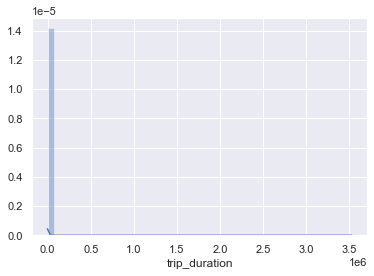

In [8]:
sns.distplot(y_train)

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

**Ответ**: Мы видим, что у распределения очень тяжелый хвост - есть значения, которые на порядок превышают медиану.

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

**Ответ**: RMSLE штрафует за отклонение в порядке величин, поэтому авторы хотели, чтобы мы не промахивались сильно с нашими предсказаниями, а их конкретное значение не настолько важно, как их порядок.

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**: ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашим выборкам колонки `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке:

In [9]:
df['log_trip_duration'] = np.log1p(df['trip_duration'])

Как мы видим, после логарифмирования распределение стало "ближе" к нормальному и у него стали менее тяжелыми хвосты:

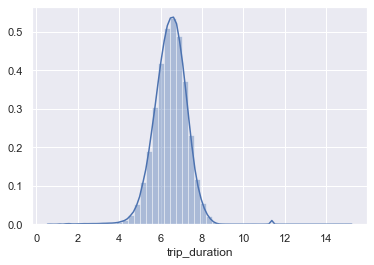

In [10]:
sns.distplot(np.log1p(y_train))

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [11]:
from sklearn.metrics import make_scorer

def rmse(y_true, y_pred):
    error = (y_true - y_pred) ** 2
    return np.sqrt(np.mean(error))

rmse_scorer = make_scorer(
    rmse,
    greater_is_better=False
)

In [12]:
X = df.drop(columns=['trip_duration', 'log_trip_duration'])
y = df['log_trip_duration']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [14]:
best_constant = y_train.mean()

print("Test RMSE with best constant = %.4f" % rmse(y_test, best_constant))
print("Train RMSE with best constant = %.4f" % rmse(y_train, best_constant))

Test RMSE with best constant = 0.7972
Train RMSE with best constant = 0.7951


## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

In [15]:
df['date'] = df['pickup_datetime'].dt.date
df = df.sort_values('date')

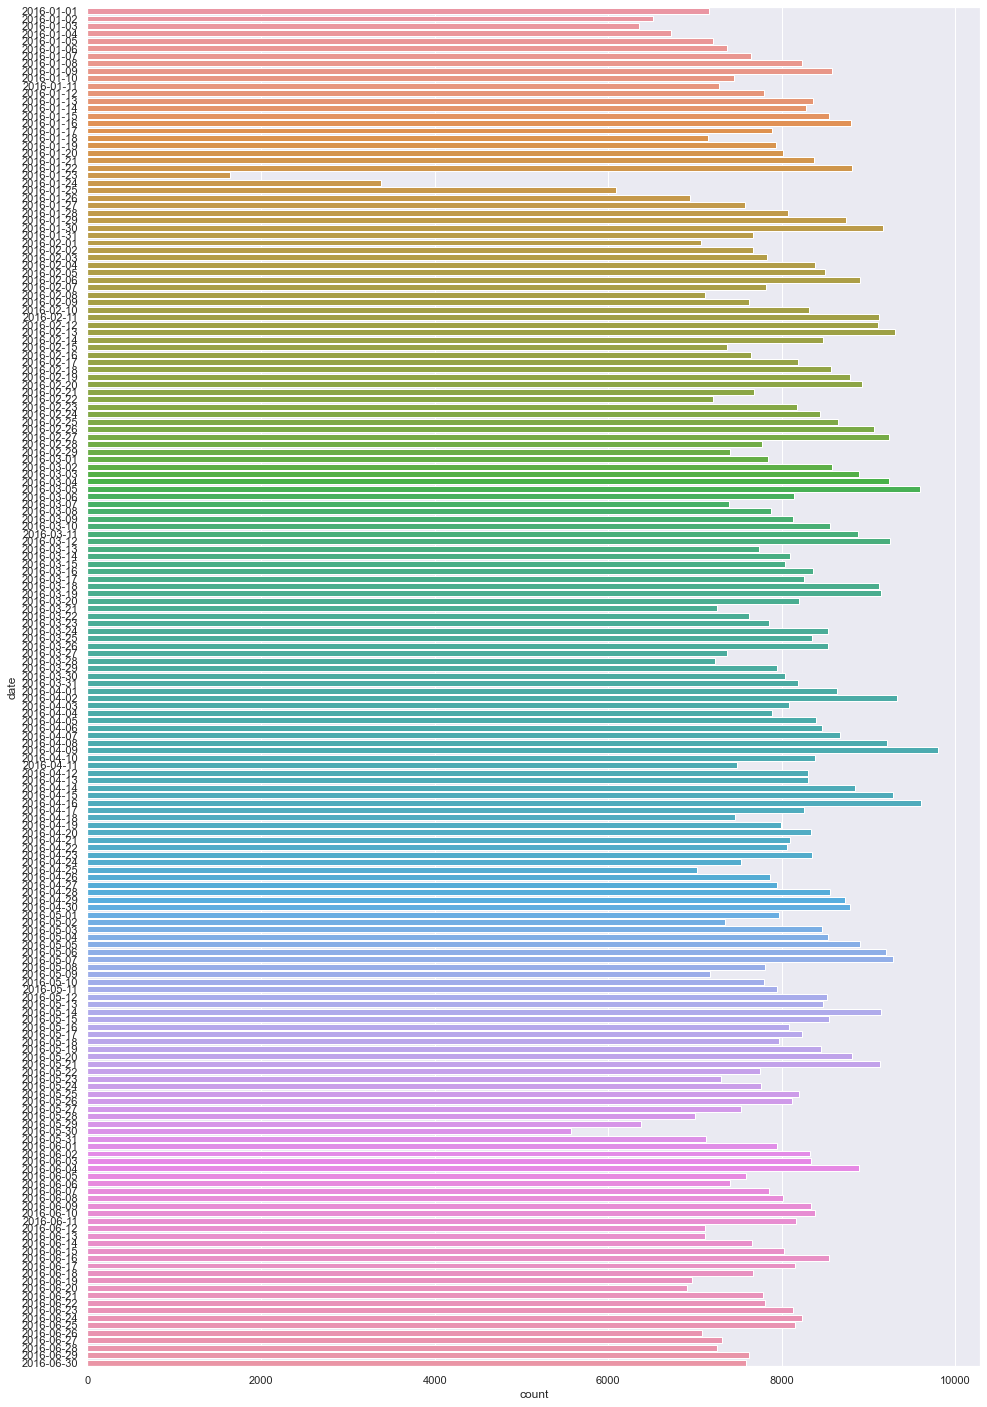

In [16]:
sns.set(rc={'figure.figsize':(16, 25)})
ax = sns.countplot(y='date', data=df)

plt.show()

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

**Ответ**: 
- 23 и 24 января 2016 года в Нью-Йорке был сильнейший снегопад.
- 30 мая 2016 - праздник, Memorial Day.

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

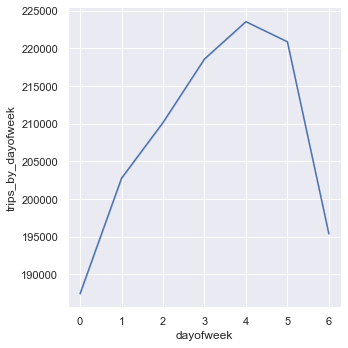

In [17]:
df['dayofweek'] = df['pickup_datetime'].dt.dayofweek
df['trips_by_dayofweek'] = df.groupby('dayofweek')['dayofweek'].transform('count')
sns.relplot(x='dayofweek', y='trips_by_dayofweek', kind='line', data = df)

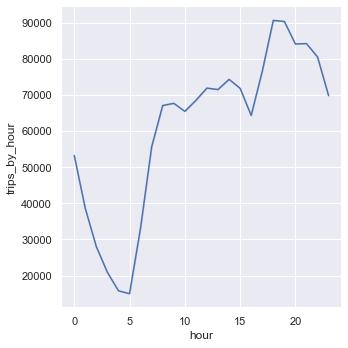

In [18]:
df['hour'] = df['pickup_datetime'].dt.hour
df['trips_by_hour'] = df.groupby('hour')['hour'].transform('count')
sns.relplot(x='hour', y='trips_by_hour', kind='line', data=df)

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

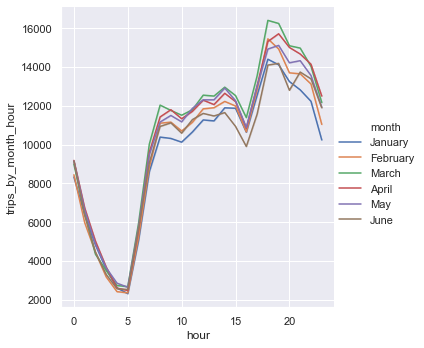

In [19]:
df['month'] = df['pickup_datetime'].dt.month_name()
df['trips_by_month_hour'] = df.groupby(['month', 'hour'])['month'].transform('count')
sns.relplot(x='hour', y='trips_by_month_hour', hue='month', kind='line', data=df)

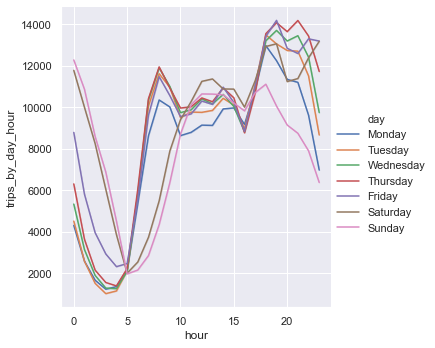

In [20]:
df['day'] = df['pickup_datetime'].dt.day_name()
df['trips_by_day_hour'] = df.groupby(['day', 'hour'])['hour'].transform('count')
sns.relplot(x='hour', y='trips_by_day_hour', hue='day', 
            hue_order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
            kind='line',
            data=df)

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

Интересные факты по месяцам:
- в весенние месяцы в целом больше поездок

Интересные факты по дням:
- в выходные дни люди начинают позже пользоваться такси
- в воскресенье вечером резко падает количество поездок, так как все по домам и готовятся к новой неделе, никто не тусит
- при этом в пятницу и в выходные ночью количество поездок сильно выше, так как люди идут куда-то развлекаться
- увеличенное число поездок в пятницу утром может говорить о том, что люди хотят приехать на работу пораньше, чтобы раньше уйти
- в понедельник количество поездок ниже, чем в другие дни недели

**Задание 4 (0.5 баллов)**. По *обучающей выборке* нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

Зависимость от часа в сутках:

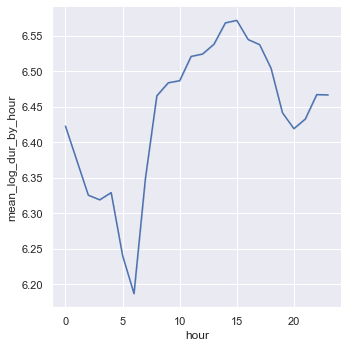

In [21]:
df['mean_log_dur_by_hour'] = df.groupby('hour')['log_trip_duration'].transform('mean')
sns.relplot(x='hour', y='mean_log_dur_by_hour', kind='line', data=df)

Зависимость от дня недели:

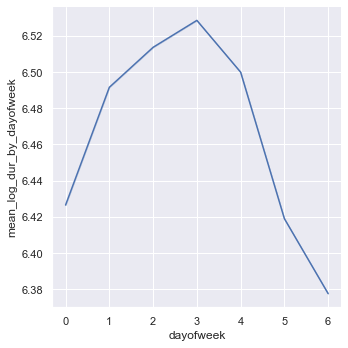

In [22]:
df['mean_log_dur_by_dayofweek'] = df.groupby('dayofweek')['log_trip_duration'].transform('mean')
sns.relplot(x='dayofweek', y='mean_log_dur_by_dayofweek', kind='line', data=df)

Зависимость от дня в году:

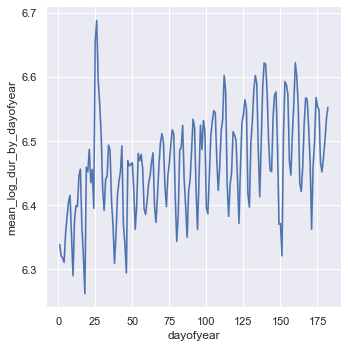

In [23]:
df['dayofyear'] = df['pickup_datetime'].dt.dayofyear
df['mean_log_dur_by_dayofyear'] = df.groupby('dayofyear')['log_trip_duration'].transform('mean')
sns.relplot(x='dayofyear', y='mean_log_dur_by_dayofyear', kind='line', data=df)

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

1. Да, похожи - чем больше поездок, тем дольше время в пути. 
2. В случае снегопада время в пути сильно росло. В случае же Memorial Day, оно сильно упало. Видимо, это связано с проведением военного парада и ограничениями на улицах.
3. Да, виден рост средней длительности поездки с начала года. Видны воскресенье и понедельник - в них спрос ниже среднего.

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [24]:
df['snowstorm'] = (df['pickup_datetime'] >= datetime(2016, 1, 23)) & \
                    (df['pickup_datetime'] < datetime(2016, 1, 25))
df['snowstorm'] = df['snowstorm'].astype(int)

df['memorial_day'] = (df['pickup_datetime'] >= datetime(2016, 5, 29)) & \
                    (df['pickup_datetime'] < datetime(2016, 5, 30))
df['memorial_day'] = df['memorial_day'].astype(int)

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков стоит рассматривать как категориальные, а какие - как численные? Почему?

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [25]:
features = ['hour', 'dayofweek', 'month', 'dayofyear', 
            'trips_by_dayofweek', 'trips_by_hour', 'trips_by_month_hour', 'trips_by_day_hour',
            'snowstorm', 'memorial_day']

In [26]:
X = df[features]
y = df['log_trip_duration']

In [27]:
categorical = ['hour', 'dayofweek', 'month', 'dayofyear']
num_feat = ['trips_by_dayofweek', 'trips_by_hour', 'trips_by_month_hour', 'trips_by_day_hour']
binary = ['snowstorm', 'memorial_day']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [29]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), num_feat)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % rmse(y_test, y_pred))
print("Test R2 score = %.4f" % r2_score(y_test, y_pred))

Test RMSE = 0.7857
Test R2 score = 0.0221


## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [30]:
from ipyleaflet import Map, Circle, LayerGroup, basemaps

In [31]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    center = (data[latitude_column].mean(), data[longitude_column].mean())
    result_map = Map(center=center, zoom=10, basemap=basemaps.Esri.NatGeoWorldMap)

    circles = []
    for _, row in data.iterrows():
        circles.append(Circle(
            location=(row[latitude_column], row[longitude_column]),
            fill_color=color,
            fill_opacity=0.2,
            radius=300,
            stroke=False
        ))
    circles_layer = LayerGroup(layers=circles)
    result_map.add_layer(circles_layer)

    return result_map

In [32]:
show_circles_on_map(df.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

Map(center=[40.75053267669678, -73.97261288452148], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [33]:
show_circles_on_map(df.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

Map(center=[40.75123262023926, -73.97420011138917], controls=(ZoomControl(options=['position', 'zoom_in_text',…

**Вопрос**: Какие две точки выделяются на карте?

**Ответ**: Два аэропорт - La Guardia и JFK.

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [34]:
def haversine(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [35]:
df['haversine'] = haversine(df['pickup_latitude'], df['pickup_longitude'], 
                                  df['dropoff_latitude'], df['dropoff_longitude'])

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку:

In [36]:
df['log_haversine'] = np.log1p(df['haversine'])

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

[('log_haversine', 0.7498822373942499), ('haversine', 0.5735948311180128)]


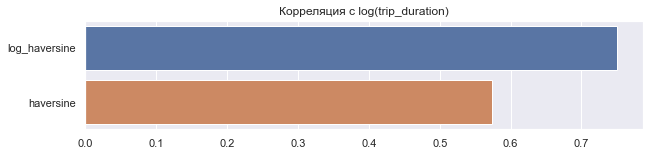

In [37]:
features_to_check = ['haversine', 'log_haversine']
correlations = {
    feature: np.corrcoef(df[feature], df['log_trip_duration'])[0][1]
    for feature in features_to_check
}

sorted_correlations = sorted(correlations.items(), key=lambda x: x[1], reverse=True)
print(sorted_correlations)
features_order = [x[0] for x in sorted_correlations]
correlations = [x[1] for x in sorted_correlations]

plot = sns.barplot(y=features_order, x=correlations)
plot = plot.set_title('Корреляция с log(trip_duration)')
plot.figure.set_size_inches(10, 2)

**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

In [38]:
df['average_speed'] = df['haversine'] / df['trip_duration']

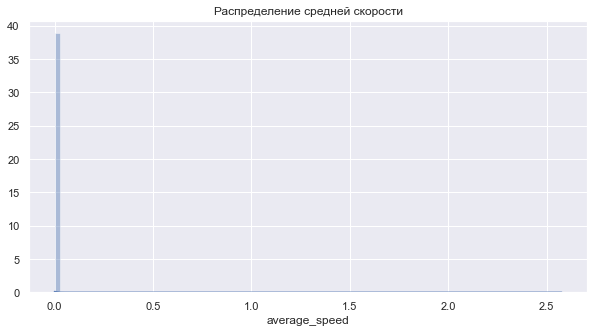

In [39]:
plot = sns.distplot(df['average_speed'], bins=100)
plot = plot.set_title('Распределение средней скорости')
plot.figure.set_size_inches(10, 5)

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

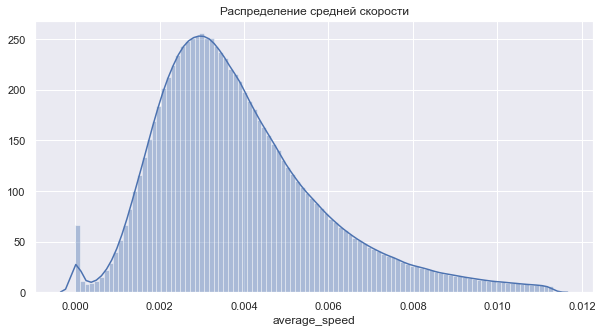

In [40]:
# считаем по 99 квантили
mask = (df['average_speed'] < np.quantile(df['average_speed'], 0.99))

plot = sns.distplot(df[mask]['average_speed'], bins=100)
plot = plot.set_title('Распределение средней скорости')
plot.figure.set_size_inches(10, 5)

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

In [41]:
mean_speed = df.groupby(['dayofweek', 'hour'], as_index=False)['average_speed'].mean()

In [42]:
pivot_table = mean_speed.pivot(index='dayofweek', columns='hour', values='average_speed')

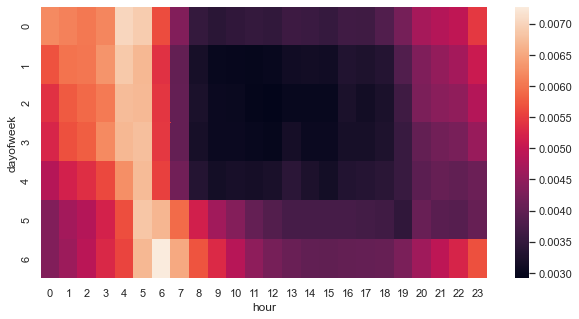

In [43]:
plot = sns.heatmap(pivot_table)
plot.figure.set_size_inches(10, 5)

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

**Ответ**: Этот признак явно содержит в себе информацию о целевой переменной, ее у нас не будет на этапе теста на бою.

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

**Ответ**: Минимальна в будние в рабочие часы, максимальна ранни утром независимо от дня недели.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [44]:
df['free_roads'] = ((df['dayofweek'] >= 0) & (df['dayofweek'] <=4) & (df['hour'] >= 4) & (df['hour'] <= 5) |
                    (df['dayofweek'] >= 5) & (df['hour'] >= 5) & (df['hour'] <= 6))
df['free_roads'] = df['free_roads'].astype(int)

In [45]:
df['heavy_traffic'] = ((df['dayofweek'] >= 1) & (df['dayofweek'] <=4) &  
                       (df['hour'] >= 8) & (df['hour'] <= 18))
df['heavy_traffic'] = df['heavy_traffic'].astype(int)

**Задание 8 (0.25 балла)**. Как уже было замечено выше, на карте выделяются две точки - аэропорты La Guardia и John F Kennedy. Для каждого из аэропортов добавьте в выборки два признака: началась ли поездка из этого аэропорта и закончилась ли поездка в этом аэропорту.

In [46]:
airport_coordinates = {'la_guardia': (40.7748153, -73.8773801), 'JFK': (40.644200, -73.782339)}

In [47]:
df['la_guardia_pickup_distance'] = haversine(df['pickup_latitude'], df['pickup_longitude'],
                                                   airport_coordinates['la_guardia'][0], 
                                                   airport_coordinates['la_guardia'][1])

df['la_guardia_dropoff_distance'] = haversine(df['dropoff_latitude'], df['dropoff_longitude'],
                                                    airport_coordinates['la_guardia'][0], 
                                                    airport_coordinates['la_guardia'][1])

df['jfk_pickup_distance'] = haversine(df['pickup_latitude'], df['pickup_longitude'],
                                                   airport_coordinates['JFK'][0], 
                                                   airport_coordinates['JFK'][1])

df['jfk_dropoff_distance'] = haversine(df['dropoff_latitude'], df['dropoff_longitude'],
                                                    airport_coordinates['JFK'][0], 
                                                    airport_coordinates['JFK'][1])

Генерация признаков отправки и прибытия в аэропортах:

In [48]:
df['la_guardia_pickup'] = df['la_guardia_pickup_distance'] < 0.4
df['la_guardia_pickup'] = df['la_guardia_pickup'].astype(int)

df['la_guardia_dropoff'] = df['la_guardia_dropoff_distance'] < 0.4
df['la_guardia_dropoff'] = df['la_guardia_dropoff'].astype(int)

In [49]:
df['jfk_pickup'] = df['jfk_pickup_distance'] < 0.4
df['jfk_pickup'] = df['jfk_pickup'].astype(int)

df['jfk_dropoff'] = df['jfk_dropoff_distance'] < 0.4
df['jfk_dropoff'] = df['jfk_dropoff'].astype(int)

In [50]:
show_circles_on_map(df[df['la_guardia_dropoff'] == 1].sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

Map(center=[40.77428614425659, -73.87312184906006], controls=(ZoomControl(options=['position', 'zoom_in_text',…

Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

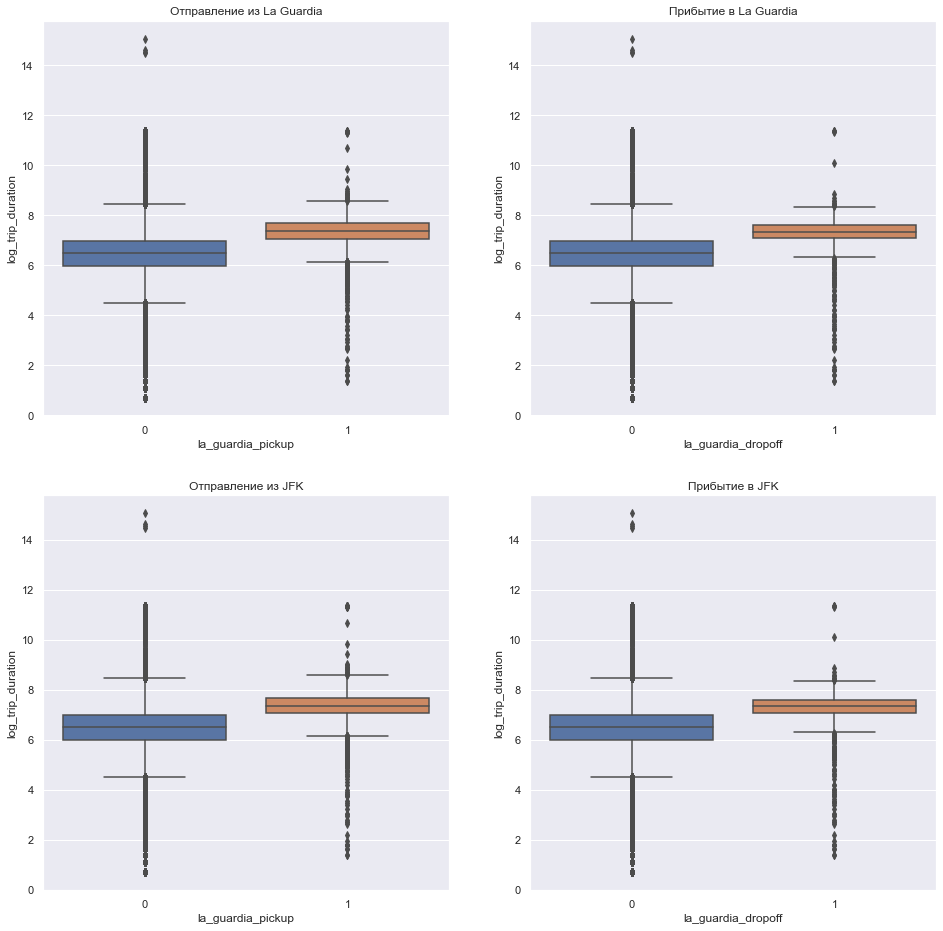

In [51]:
fig, axes = plt.subplots(2, 2, figsize=(16, 16))

axes[0, 0].set_title('Отправление из La Guardia')
sns.boxplot(x='la_guardia_pickup', y='log_trip_duration', data=df, ax=axes[0, 0])
axes[0, 1].set_title('Прибытие в La Guardia')
sns.boxplot(x='la_guardia_dropoff', y='log_trip_duration', data=df, ax=axes[0, 1])

axes[1, 0].set_title('Отправление из JFK')
sns.boxplot(x='la_guardia_pickup', y='log_trip_duration', data=df, ax=axes[1, 0])
axes[1, 1].set_title('Прибытие в JFK')
sns.boxplot(x='la_guardia_dropoff', y='log_trip_duration', data=df, ax=axes[1, 1])

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

**Ответ**: Как мы видим, время поездки из/в аэропорт в среднем больше, чем в остальном по выборке, поэтому эти признаки должны быть хорошими.

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [52]:
from sklearn.base import BaseEstimator, TransformerMixin

class MapGridTransformer(BaseEstimator, TransformerMixin):
    pass

**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, численные признаки отмасштабируйте.

In [53]:
features = ['hour', 'dayofweek', 'month', 'dayofyear', 
            'trips_by_dayofweek', 'trips_by_hour', 'trips_by_month_hour', 'trips_by_day_hour',
            'snowstorm', 'memorial_day',
            'log_haversine', 
            'free_roads', 'heavy_traffic',
            'la_guardia_pickup', 'la_guardia_dropoff', 'jfk_pickup', 'jfk_dropoff']

In [54]:
X = df[features]
y = df['log_trip_duration']

In [55]:
categorical = ['hour', 'dayofweek', 'month', 'dayofyear']
num_feat = ['trips_by_dayofweek', 'trips_by_hour', 'trips_by_month_hour', 'trips_by_day_hour', 'log_haversine']
binary = ['snowstorm', 'memorial_day', 'free_roads', 'heavy_traffic',
          'la_guardia_pickup', 'la_guardia_dropoff', 'jfk_pickup', 'jfk_dropoff']

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [57]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), num_feat)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % rmse(y_test, y_pred))
print("Test R2 score = %.4f" % r2_score(y_test, y_pred))
print("")

Test RMSE = 0.4953
Test R2 score = 0.6115



## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

**Ответ**:
1. vendor_id - может быть какая-то разница в скорости езды водителей или районов, по которым работают фирмы, что будет сказываться на длительности поездки.
2. passenger_count - если в машине несколько пассажиров, то есть вероятность, что их будут развозить по разным точкам, из-за чего время в поездке будет больше
3. store_and_fwd_flag - не до конца понял, что это за признак

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [58]:
df['vendor_id'].value_counts()

2    780302
1    678342
Name: vendor_id, dtype: int64

In [59]:
df['passenger_count'].value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64

In [60]:
df['store_and_fwd_flag'].value_counts()

N    1450599
Y       8045
Name: store_and_fwd_flag, dtype: int64

Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

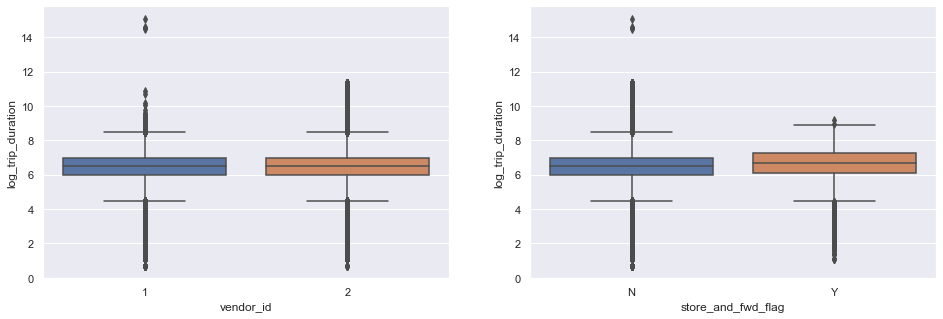

In [61]:
fig, axes = plt.subplots(1, 2, figsize = (16, 5))
sns.boxplot(y='log_trip_duration', x='vendor_id', data=df, ax=axes[0])
sns.boxplot(y='log_trip_duration', x='store_and_fwd_flag', data=df, ax=axes[1])

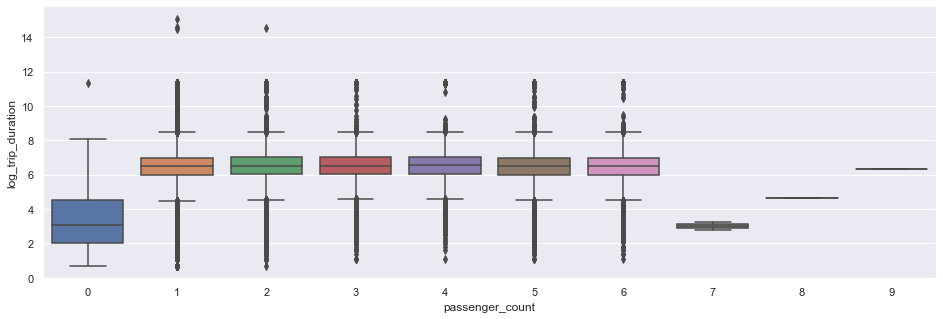

In [62]:
fig, axes = plt.subplots(1, figsize=(16, 5))
sns.boxplot(y='log_trip_duration', x='passenger_count', data=df)

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [63]:
df['vendor_id'] = df['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
df['vendor_id'] = df['vendor_id'].astype(int)

In [64]:
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].apply(lambda s: 0 if s == 'N' else 1)
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].astype(int)

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

**Ответ**: В `store_and_fwd_flag` видно различие по целевой переменной, возможно, там будет разница. В `passenger_count` за счет бинаризации может быть что-то интересное.

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [65]:
features = ['hour', 'dayofweek', 'month', 'dayofyear', 
            'trips_by_dayofweek', 'trips_by_hour', 'trips_by_month_hour', 'trips_by_day_hour',
            'snowstorm', 'memorial_day',
            'log_haversine', 
            'free_roads', 'heavy_traffic',
            'la_guardia_pickup', 'la_guardia_dropoff', 'jfk_pickup', 'jfk_dropoff',
            'passenger_count',
            'vendor_id', 'store_and_fwd_flag']

In [66]:
X = df[features]
y = df['log_trip_duration']

In [67]:
categorical = ['hour', 'dayofweek', 'month', 'dayofyear', 'passenger_count']
num_feat = ['trips_by_dayofweek', 'trips_by_hour', 'trips_by_month_hour', 'trips_by_day_hour', 'log_haversine']
binary = ['snowstorm', 'memorial_day', 'free_roads', 'heavy_traffic',
          'la_guardia_pickup', 'la_guardia_dropoff', 'jfk_pickup', 'jfk_dropoff', 
          'vendor_id', 'store_and_fwd_flag']

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [69]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), num_feat)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % rmse(y_test, y_pred))
print("Test R2 score = %.4f" % r2_score(y_test, y_pred))
print("")

Test RMSE = 0.4950
Test R2 score = 0.6118



Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты: с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите обучающую выборку от них.

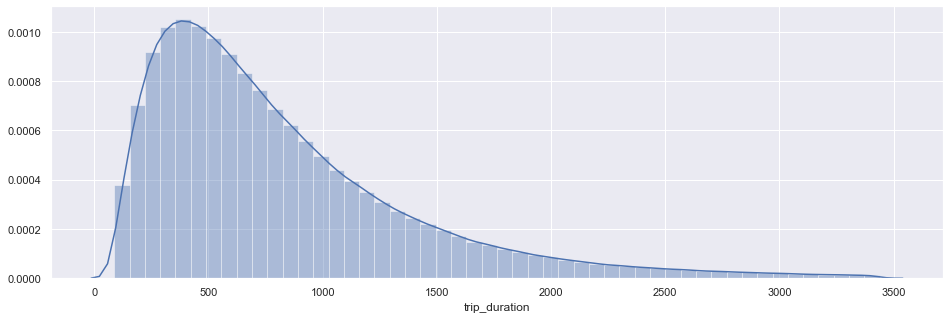

In [78]:
mask = ((np.quantile(df['trip_duration'], 0.01) < df['trip_duration']) & 
        (df['trip_duration'] < np.quantile(df['trip_duration'], 0.99)))
sns.set(rc={'figure.figsize':(16, 5)})
sns.distplot(df[mask]['trip_duration'])

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Попробуйте объединить редкие категории в одну. Естественно, делать это нужно только для действительно редких категорий.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

In [79]:
features = ['hour', 'dayofweek', 'month', 'dayofyear', 
            'trips_by_dayofweek', 'trips_by_hour', 'trips_by_month_hour', 'trips_by_day_hour',
            'snowstorm', 'memorial_day',
            'log_haversine', 
            'free_roads', 'heavy_traffic',
            'la_guardia_pickup', 'la_guardia_dropoff', 'jfk_pickup', 'jfk_dropoff',
            'passenger_count',
            'vendor_id', 'store_and_fwd_flag']

In [80]:
mask = ((np.quantile(df['trip_duration'], 0.01) < df['trip_duration']) & 
        (df['trip_duration'] < np.quantile(df['trip_duration'], 0.99)))

In [81]:
X = df[mask][features]
y = df[mask]['log_trip_duration']

In [82]:
categorical = ['hour', 'dayofweek', 'month', 'dayofyear', 'passenger_count']
num_feat = ['trips_by_dayofweek', 'trips_by_hour', 'trips_by_month_hour', 'trips_by_day_hour', 'log_haversine']
binary = ['snowstorm', 'memorial_day', 'free_roads', 'heavy_traffic',
          'la_guardia_pickup', 'la_guardia_dropoff', 'jfk_pickup', 'jfk_dropoff', 
          'vendor_id', 'store_and_fwd_flag']

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [84]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), num_feat)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % rmse(y_test, y_pred))
print("Test R2 score = %.4f" % r2_score(y_test, y_pred))
print("")

Test RMSE = 0.4155
Test R2 score = 0.6460



**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Стало ли лучше?

In [86]:
features = ['hour', 'dayofweek', 'month', 'dayofyear', 
            'trips_by_dayofweek', 'trips_by_hour', 'trips_by_month_hour', 'trips_by_day_hour',
            'snowstorm', 'memorial_day',
            'log_haversine', 
            'free_roads', 'heavy_traffic',
            'la_guardia_pickup', 'la_guardia_dropoff', 'jfk_pickup', 'jfk_dropoff',
            'passenger_count',
            'vendor_id', 'store_and_fwd_flag']

In [87]:
mask = ((np.quantile(df['trip_duration'], 0.01) < df['trip_duration']) & 
        (df['trip_duration'] < np.quantile(df['trip_duration'], 0.99)))

In [88]:
X = df[mask][features]
y = df[mask]['log_trip_duration']

In [89]:
categorical = ['hour', 'dayofweek', 'month', 'dayofyear', 'passenger_count']
num_feat = ['trips_by_dayofweek', 'trips_by_hour', 'trips_by_month_hour', 'trips_by_day_hour', 'log_haversine']
binary = ['snowstorm', 'memorial_day', 'free_roads', 'heavy_traffic',
          'la_guardia_pickup', 'la_guardia_dropoff', 'jfk_pickup', 'jfk_dropoff', 
          'vendor_id', 'store_and_fwd_flag']

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [91]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), num_feat)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % rmse(y_test, y_pred))
print("Test R2 score = %.4f" % r2_score(y_test, y_pred))
print("")

Test RMSE = 0.6985
Test R2 score = -0.0000



Разбейте обучающую выборку на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальное значение параметра регуляризации (по логарифмической сетке), на тестовой выборке измерьте качество полученной модели.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Для каждого перебранного `alpha` посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими редкими парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Переобучите модель на новых даннных и посчитайте качество на тестовой выборке

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут). 

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Переобучите модель на новых даннных и посчитайте качество на тестовой выборке

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ